# Approach to Comparing Player 15411 Against Other Fielders

## Problem Overview
The dataset provided includes various attributes of each pitch, including information about the ball's exit speed, vertical and horizontal exit angles, and the defensive players involved. However, the `first_fielder` column only contains values when the ball was caught for an out (`is_airout == 1`), limiting our ability to compare fielders using this column alone.

## Objective
Our goal is to compare **player 15411** (center fielder)) against all other center fielders in the league without relying on the `first_fielder` column. Instead, we will try assign responsibility for every batted ball to a fielder using two methods. 

The first method assigns responsibility based on its **horizontal exit angle** and calculates performance metrics based on total opportunities and airouts. However, this approach has its **limitations** since we don't know the wind speed or spin-axis for the ball, which could change its trajectory, and thus which fielder should be responsible for fielding it (ex., wind pushes the ball towards center field instead of right). Also, it doesn't incorporate the shifts that teams may have for their outfielders. As a result, solely relying on the horizontal exit angle can result in misassignments.

The second method uses a random forest classifier to predict the outfielder responsible for the fly ball. The model has an accuracy of ~86% which is alright and can be improved, but given more information such as spin axis, wind, etc we could increase the model's accuracy. 



## Steps for Measuring Efficiency of Fielders

### 1. Assign Responsibility Based on Horizontal Exit Angle
We divide the field into zones based on the **horizontal exit angle** of the ball:

- **Center Fielder (CF)**: Responsible for balls with horizontal exit angles between -14.76 and 13.3 degrees (explaination in code below).


Using these zones, we assign responsibility for each batted ball, regardless of whether it was caught for an air out or not.

### 2. Assign Actual Fielders
Once responsibility is determined based on the horizontal exit angle, we use the player IDs from the columns `lf_id`, `cf_id`, and `rf_id` to identify the actual fielder responsible for the play.

### 3. Calculate Total Opportunities and Air Outs
For each fielder, we calculate:
- **Total Opportunities**: The total number of balls hit into the fielder's zone, including both catches and misses.
- **Total Air Outs**: The total number of successful air outs (`is_airout == 1`) made by the fielder.

### 4. Calculate Efficiency
To measure performance, we compute the **efficiency** for each fielder as:
$$
{Efficiency} = \frac{\text{Total Air Outs}}{\text{Total Opportunities}}
$$
This efficiency score reflects how successful a fielder is at converting opportunities into outs.

## Future Work

Additionally, evaluating the difficulty of a play provides valuable insights into player performance. By considering several features of a batted ball—such as its exit speed, launch angles, and spin rate—we can create a **difficulty score** that quantifies how challenging a particular play was for the fielder responsible. However, it is challenging to value the difficulty of a fly ball since it is possible not all variables are equally important in determining the difficulty of a ball and different variables are measured in different units. Nonetheless, the process below is an example approach for the implementation of a difficult score.

## Steps for Measuring Difficulty of play made by fielders

### 1. Standardize the Features
Since these features are measured in different units (e.g., exit speed in miles per hour, angles in degrees, spin rate in rotations per minute), they need to be standardized so they can be compared on the same scale.

### 2. Calculate the Difficulty Score
Once the features are standardized, they are summed to compute the difficulty score for each play. Optionally, you can assign different weights to each feature if certain metrics (like exit speed) are considered more important. In the absence of weighting, each feature is treated equally in the sum.

### 3. Assign the Difficulty Score to the Fielder
After calculating the difficulty score for each play, it can be assigned to the fielder who was responsible for the play, allowing us to evaluate their performance in handling difficult plays.

In [249]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler

In [292]:
df = pd.read_csv('data-train.csv')

## Create a function to calculate the distance a ball will travel given its velocity and exit angle

Will be used to filter out home run balls so that fielders aren't evaluated on those balls

In [189]:
import numpy as np

# Function to calculate distance based on exit speed and vertical exit angle
def calculate_distance(exit_speed, vert_exit_angle):
    # Convert exit speed from mph to meters per second (1 mph = 0.44704 m/s)
    exit_speed_mps = exit_speed * 0.44704

    # Convert vertical exit angle from degrees to radians
    vert_exit_angle_rad = np.radians(vert_exit_angle)

    # Acceleration due to gravity (m/s^2)
    g = 9.81

    # Calculate the distance using the projectile motion formula
    distance = (exit_speed_mps**2 * np.sin(2 * vert_exit_angle_rad)) / g
    
    # Convert the distance back to feet (1 meter = 3.28084 feet)
    distance_ft = distance * 3.28084
    
    return distance_ft

# Example usage
exit_speed = 100  # mph
vert_exit_angle = 30  # degrees
estimated_distance = calculate_distance(exit_speed, vert_exit_angle)
print(f"Estimated distance: {estimated_distance:.2f} feet")


Estimated distance: 578.81 feet


## Implementation of assigning which fielder is responsible for a ball based on its horizontal angle

After assigning which fielder is responsible, calculate the efficiency for each fielder_id and compare it to player 15411

## Process

1. Horizontal exit angles for foul balls should be set with statistics from existing data instead of arbitrary -90 and 90 degrees.
2. same goes with the field assignment. Use the statistic (mean + 2*std) which will capture 95% of the horizontal angles that center fielders have been responsible for.
3. As 15411 is center fielder, should we just compare him with all other center fielder in terms of efficiency

In [424]:
df_tmp = df.copy()

df_tmp.dropna(subset=['first_fielder'], inplace=True)

df_tmp['first_fielder'] = df_tmp['first_fielder'].astype(int)

### For the horizontal exit angle for balls that were caught, the max is 60.18 degrees and min is -69.86 so assume that this is the range for all catchable balls

In [427]:
# this includes every ball
print("ALL DATA")
display(df[['horz_exit_angle']].describe())


print("Only the data that airout is true")
input_features = [ 'horz_exit_angle', 'hit_spin_rate',
       'vert_exit_angle', 'exit_speed']
df_tmp[input_features].describe()

ALL DATA


,horz_exit_angle
count,91553.000000
mean,2.071675
std,60.988812
min,-179.989000
25%,-21.495800
50%,0.489532
75%,23.590000
max,179.943000


Only the data that airout is true


,horz_exit_angle,hit_spin_rate,vert_exit_angle,exit_speed
count,34058.000000,33226.000000,34058.000000,34058.000000
mean,-0.076981,3061.015659,33.969020,90.295030
std,15.922606,1196.510176,10.989078,8.010069
min,-69.857500,167.001000,9.678282,63.730070
25%,-12.115467,2088.797500,25.296434,84.880950
50%,-0.237675,3038.823756,33.463550,90.849930
75%,12.204905,3991.422210,42.038866,96.204718
max,60.182400,7973.980000,69.261900,115.679000


### Looking at horizontal angle for each fielder (right, center, and left)

In [430]:
for f_id in ['lf_id', 'cf_id', 'rf_id']:
    df_field= df_tmp[df_tmp['first_fielder']==df_tmp[f_id]]
    display(df_field[input_features].describe())

,horz_exit_angle,hit_spin_rate,vert_exit_angle,exit_speed
count,9645.000000,9358.000000,9645.000000,9645.000000
mean,-18.710678,3177.154034,35.221432,88.512263
std,7.544702,1242.336740,11.746830,8.086804
min,-69.857500,195.963000,10.548733,63.730070
25%,-23.858952,2141.535474,25.645084,82.988600
50%,-18.781820,3237.564065,35.146454,88.664760
75%,-13.652093,4162.666009,44.421766,94.119700
max,16.569229,7973.980000,69.261900,115.679000


,horz_exit_angle,hit_spin_rate,vert_exit_angle,exit_speed
count,14052.000000,13889.000000,14052.000000,14052.000000
mean,-0.716569,2803.037734,32.203190,92.519726
std,7.037893,1099.138102,9.902645,7.550639
min,-27.372400,167.001000,9.678282,67.278380
25%,-5.665390,1936.703902,24.538035,87.720735
50%,-0.737861,2748.319331,31.582939,93.516600
75%,4.117287,3621.150000,39.005967,98.069553
max,32.975900,7512.807781,63.830100,113.996000


,horz_exit_angle,hit_spin_rate,vert_exit_angle,exit_speed
count,10361.000000,9979.000000,10361.000000,10361.000000
mean,18.136462,3311.164221,35.198047,88.937377
std,7.596437,1212.588916,11.328252,7.823328
min,-28.357000,240.330000,10.266689,65.940600
25%,12.853500,2328.435000,26.305500,83.713760
50%,18.070479,3370.080000,35.101900,89.447610
75%,23.399359,4293.187244,43.794915,94.420000
max,60.182400,6428.743977,65.771100,113.270000


### Looking at centerfielders, we can use -0.7 +/- 2*7.03 (2 std covers 95% of the data)

Thus, horz_exit_angle between -14.76 and 13.36 are opportunities for center fielder. 

In [437]:
-0.7-2*7.03

-14.76

In [440]:
-0.7+2*7.03

13.360000000000001

In [451]:
import pandas as pd

# Step 0: Define filtering conditions to exclude foul balls and home runs
# Define foul territory as extreme horizontal exit angles (example: angles < -90 or > 90 degrees)
foul_territory = (-69.857500, 60.182400)

# Filter out foul balls and home runs (if home runs are indicated in your data)
# Adjust the condition based on how home runs are represented (e.g., `is_home_run` or inferred from exit speed/launch angle)
df_filtered = df[(df['horz_exit_angle'] >= foul_territory[0]) & (df['horz_exit_angle'] <= foul_territory[1])]

# filter out balls that travel more than 400ft (avg homerun distance)
# Apply the function to calculate distance for each row in the DataFrame
df_filtered['estimated_distance'] = df_filtered.apply(
    lambda row: calculate_distance(row['exit_speed'], row['vert_exit_angle']), axis=1
)

# Filter out rows where the estimated distance is greater than 400 feet
df_filtered = df_filtered[df_filtered['estimated_distance'] <= 400]


# Step 1: Define responsibility based on horizontal exit angle
def assign_fielder_zone(horz_exit_angle):
    if horz_exit_angle <= -14.76:  # Left field zone
        return 'LF'
    elif -14.76 < horz_exit_angle <= 13.360000000000001:  # Center field zone
        return 'CF'
    else:  # Right field zone
        return 'RF'

# Apply the function to create a new column for assigned responsibility
df_filtered['responsible_zone'] = df_filtered['horz_exit_angle'].apply(assign_fielder_zone)

# Step 2: Assign actual fielder based on their zone responsibility
def assign_fielder(row):
    if row['responsible_zone'] == 'LF':
        return row['lf_id']
    elif row['responsible_zone'] == 'CF':
        return row['cf_id']
    else:
        return row['rf_id']

# Assign the fielder who is responsible for the play
df_filtered['fielder_id'] = df_filtered.apply(assign_fielder, axis=1)

# Filter for only centerfielders by selecting entries where `responsible_zone` is 'CF'
cf_stats = df_filtered[df_filtered['responsible_zone'] == 'CF']

# Recalculate fielder_stats but only for centerfielders
cf_fielder_stats = cf_stats.groupby('fielder_id').agg(
    total_opportunities=('is_airout', 'size'),
    total_airouts=('is_airout', 'sum')
).reset_index()

# Step 4: Calculate efficiency for centerfielders only
cf_fielder_stats['efficiency'] = cf_fielder_stats['total_airouts'] / cf_fielder_stats['total_opportunities']

# Step 5: Compare player 15411 to the league (only centerfielders)
player_15411_stats = cf_fielder_stats[cf_fielder_stats['fielder_id'] == 15411]
league_stats = cf_fielder_stats[cf_fielder_stats['fielder_id'] != 15411]

print("Player 15411's stats:\n", player_15411_stats)
print("League average stats for centerfielders:\n", league_stats.mean())


Player 15411's stats:
      fielder_id  total_opportunities  total_airouts  efficiency
148       15411                  205             81    0.395122
League average stats for centerfielders:
 fielder_id             51380.438710
total_opportunities       37.174194
total_airouts             14.022581
efficiency                 0.360578
dtype: float64


/var/folders/1s/2gfv98317bnc5_7xb_2604sc0000gp/T/ipykernel_61923/2273668524.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['estimated_distance'] = df_filtered.apply(


## Box and Whisker Plot to visualize Player 15411 vs the rest of the league

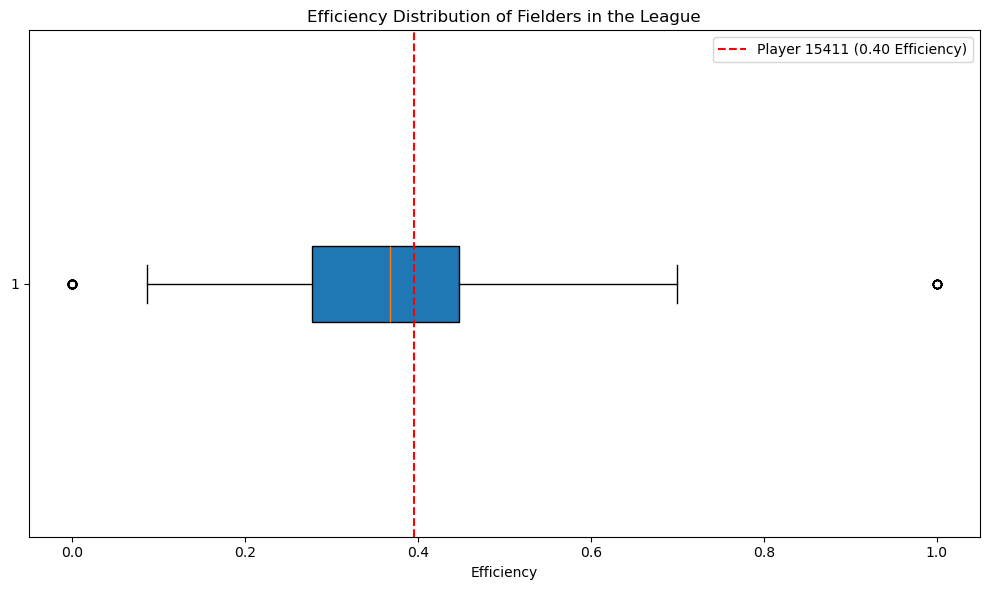

In [454]:
import matplotlib.pyplot as plt

# Step 6: Plot a box and whisker plot for efficiency across the league, excluding player 15411
plt.figure(figsize=(10,6))

# Boxplot for league efficiency excluding player 15411
plt.boxplot(league_stats['efficiency'], vert=False, patch_artist=True)

# Add a vertical line for player 15411's efficiency
player_15411_efficiency = player_15411_stats['efficiency'].values[0]
plt.axvline(player_15411_efficiency, color='red', linestyle='--', label=f'Player 15411 ({player_15411_efficiency:.2f} Efficiency)')

# Add labels and title
plt.xlabel('Efficiency')
plt.title('Efficiency Distribution of Fielders in the League')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Train a random forest classifier to determine which fielder is responsible for a ball

In [480]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df_model = df.copy()

# Conditions and choices
conditions = [
    df_model['lf_id'] == df_model['first_fielder'],
    df_model['cf_id'] == df_model['first_fielder'],
    df_model['rf_id'] == df_model['first_fielder']
]
choices = ["LF", "CF", "RF"]

# Apply np.select and drop rows where no conditions were met
df_model['fielder'] = np.select(conditions, choices, default=None)
df_model = df_model.dropna(subset=['first_fielder'])

df_model.shape

(34058, 22)

## Achieves a 86% accuracy score

In [483]:
# Select features and target
features = df_model[['exit_speed', 'vert_exit_angle', 'horz_exit_angle', 'hit_spin_rate']]
target = df_model['fielder']

# Split data
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize, train, and evaluate the classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Accuracy: 0.8656782149148561
              precision    recall  f1-score   support

          CF       0.82      0.86      0.84      2751
          LF       0.90      0.86      0.88      1907
          RF       0.90      0.88      0.89      2154

    accuracy                           0.87      6812
   macro avg       0.87      0.87      0.87      6812
weighted avg       0.87      0.87      0.87      6812



## Calculate efficiency of fielders using RFC

In [486]:
# Step 0: Define filtering conditions to exclude foul balls and home runs
foul_territory = (-69.857500, 60.182400)
df_test = df.copy()

df_test = df_test[(df_test['horz_exit_angle'] >= foul_territory[0]) & (df_test['horz_exit_angle'] <= foul_territory[1])]

# Estimate distance and filter out balls that travel more than 400 feet (home run)
df_test['estimated_distance'] = df_test.apply(
    lambda row: calculate_distance(row['exit_speed'], row['vert_exit_angle']), axis=1
)
df_test = df_test[df_test['estimated_distance'] <= 400]

df_test[df_test['first_fielder'] == 15411].shape

(57, 22)

In [488]:
# Step 1: Use the RFC model to predict the responsible fielder (LF, CF, or RF)
features = df_test[['exit_speed', 'vert_exit_angle', 'horz_exit_angle', 'hit_spin_rate']]
df_test['responsible_zone'] = clf.predict(features)  # Predict responsible fielder zone

# Step 2: Initialize `fielder_id` by copying `first_fielder` values where available
df_test['fielder_id'] = df_test['first_fielder']

# Step 3: Assign `lf_id`, `cf_id`, or `rf_id` to `fielder_id` based on `responsible_zone`
# only for rows where `first_fielder` is NaN
df_test.loc[df_test['first_fielder'].isna() & (df_test['responsible_zone'] == 'LF'), 'fielder_id'] = df_test['lf_id']
df_test.loc[df_test['first_fielder'].isna() & (df_test['responsible_zone'] == 'CF'), 'fielder_id'] = df_test['cf_id']
df_test.loc[df_test['first_fielder'].isna() & (df_test['responsible_zone'] == 'RF'), 'fielder_id'] = df_test['rf_id']


In [496]:
# Filter for only centerfielders by selecting entries where `responsible_zone` is 'CF'
cf_stats = df_test[df_test['responsible_zone'] == 'CF']

# Recalculate fielder_stats but only for centerfielders
cf_fielder_stats = cf_stats.groupby('fielder_id').agg(
    total_opportunities=('is_airout', 'size'),
    total_airouts=('is_airout', 'sum')
).reset_index()

# Step 4: Calculate efficiency for centerfielders only
cf_fielder_stats['efficiency'] = cf_fielder_stats['total_airouts'] / cf_fielder_stats['total_opportunities']

# Step 5: Compare player 15411 to the league (only centerfielders)
player_15411_stats = cf_fielder_stats[cf_fielder_stats['fielder_id'] == 15411]
league_stats = cf_fielder_stats[cf_fielder_stats['fielder_id'] != 15411]

print("Player 15411's stats:\n", player_15411_stats)
print("League average stats for centerfielders:\n", league_stats.mean())

Player 15411's stats:
      fielder_id  total_opportunities  total_airouts  efficiency
152     15411.0                  145             56    0.386207
League average stats for centerfielders:
 fielder_id             50240.707692
total_opportunities       24.575385
total_airouts              9.403077
efficiency                 0.425273
dtype: float64


## Plot results using Box and Whiskers plot

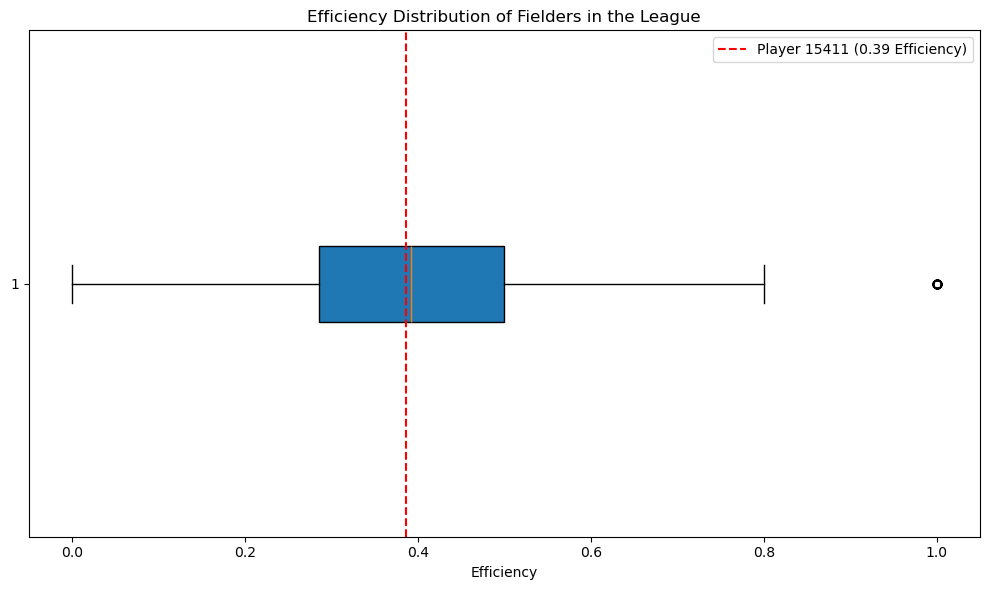

In [499]:
# Step 6: Plot a box and whisker plot for efficiency across the league, excluding player 15411
plt.figure(figsize=(10,6))

# Boxplot for league efficiency excluding player 15411
plt.boxplot(league_stats['efficiency'], vert=False, patch_artist=True)

# Add a vertical line for player 15411's efficiency
player_15411_efficiency = player_15411_stats['efficiency'].values[0]
plt.axvline(player_15411_efficiency, color='red', linestyle='--', label=f'Player 15411 ({player_15411_efficiency:.2f} Efficiency)')

# Add labels and title
plt.xlabel('Efficiency')
plt.title('Efficiency Distribution of Fielders in the League')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()